# Rotation and translation of original image


First, we assessed the feasibility of our approach - Can we apply the open3D functions to register our images of zebrafish tailbuds successfully? We reasoned that at bare minimum, for a registration algorithm to have any potential at all at registering separately acquired tailbud images, it must recover the correspondence map between an image and its near-duplicate. In this instance, as we created a near-duplicate that differs from its original merely by rotation and translation operations, we demanded the recovery to be **exact**.

**Objective**: 

Given two images A and A' where A' is identical to image A except for an arbitrary spatial rotation and translation, we assess whether the algorithms are able to recover the exact mapping between image A and A'. 

**Procedure**: 

1. Image A' is generated by randomly rotating and translating the target image in space, and importing the spatial coordinates as a pandas DataFrame.

2. We randomly shuffle the rows of the dataframe of image A' to challenge the algorithms to find the new correspondence map.

3. We visually inspect the results to gather a first impression of the alignment. Following that, the accuracy of the mapping is quantified via the *fitness* and inlier RMSE of the registration, as well as the mean absolute error of sox2 expression between the aligned and original images. 


In [1]:
import numpy as np 
import pandas as pd
import open3d as o3d
import copy
import matplotlib.pyplot as plt

from data_processing import excel_to_pcd, preprocess_point_cloud, colour_map
from align_func import execute_global_registration, icp_registration, colored_icp, calculate_mae


In [2]:
def process_image_for_rotation_test(positions_paths,color_path, cmap = "viridis"):
    pcd_list = []
    fpfh_list = []
    color_excel = [pd.read_excel(color_path, skiprows = [0], header = 0, usecols = [0])]
    image_color = color_excel[0].to_numpy(dtype='float64')
    image_rgb, image_col_range = colour_map(image_color,cmap)

    for path in positions_paths:
        image_excel = [pd.read_excel(path, skiprows = [0], header = 0, usecols = [0,1,2])]
        image_pcd = excel_to_pcd(image_excel, [path], return_filenames = True)
        image = o3d.io.read_point_cloud(image_pcd[0]) #sample.pcd is the source
        image_processed, image_fpfh = preprocess_point_cloud(image)
        image_processed.colors=o3d.utility.Vector3dVector(image_rgb)
        pcd_list.append(image_processed)
        fpfh_list.append(image_fpfh)
    return pcd_list, fpfh_list, image_rgb

In [3]:
target_path = "./datasets/1-rotation/xyz_target.xls"
rotated_target_path = "./datasets/1-rotation/rotated_xyz_target.xls"
color_path = "./datasets/1-rotation/sox2_target.xls"
positions_paths = [target_path] + [rotated_target_path]

pcd,fpfh,image_rgb = process_image_for_rotation_test(positions_paths, color_path)

:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------


In [4]:
target, target_rotated = pcd
target_fpfh, target_rotated_fpfh = fpfh

## RANSAC algorithm

In [5]:
result_ransac_rotate = execute_global_registration(target_rotated, target,
                                            target_rotated_fpfh, target_fpfh)

target_rotated_aligned_ransac = copy.deepcopy(target_rotated)
target_rotated_aligned_ransac.transform(result_ransac_rotate.transformation)

geometry::PointCloud with 3791 points.

## ICP algorithm

In [6]:
result_icp = icp_registration(target_rotated, target, target_rotated_fpfh, target_fpfh, result_ransac_rotate.transformation)

target_rotated_aligned_icp= copy.deepcopy(target_rotated)
target_rotated_aligned_icp.transform(result_icp.transformation)

geometry::PointCloud with 3791 points.

## Colored ICP algorithm

In [7]:
result_colored_icp = colored_icp(target_rotated, target, result_ransac_rotate.transformation, voxel_radius = 10, coloredICP_maxnn = 50, downsample = False)

target_rotated_aligned_colored_icp= copy.deepcopy(target_rotated)
target_rotated_aligned_colored_icp.transform(result_colored_icp.transformation)

geometry::PointCloud with 3791 points.

# Results


In [8]:
print(":: \n Unaligned")
evaluation = o3d.registration.evaluate_registration(target, target_rotated, 10)
print(evaluation)

print(":: \n result_ransac_rotate of RANSAC global registration: ")
print(result_ransac_rotate)
print(f"\n % mapped: {len(result_ransac_rotate.correspondence_set)/len(np.asarray(target.points))*100:.0f}%")


print(":: \n Result of ICP registration")
print(result_icp)
print(f"\n % mapped: {len(result_icp.correspondence_set)/len(np.asarray(target.points))*100:.0f}%")

print(":: \n Result of Colored ICP registration ")
print(result_colored_icp)
print(f"\n % mapped: {len(result_colored_icp.correspondence_set)/len(np.asarray(target.points))*100:.0f}%")
print(f"\n MAE: {calculate_mae(image_rgb, image_rgb, result_colored_icp)}")

:: 
 Unaligned
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
:: 
 result_ransac_rotate of RANSAC global registration: 
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.827812e-04, and correspondence_set size of 3791
Access transformation to get result.

 % mapped: 100%
:: 
 Result of ICP registration
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.778820e-04, and correspondence_set size of 3791
Access transformation to get result.

 % mapped: 100%
:: 
 Result of Colored ICP registration 
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.780918e-04, and correspondence_set size of 3791
Access transformation to get result.

 % mapped: 100%

 MAE: 0.0


# Visualisations

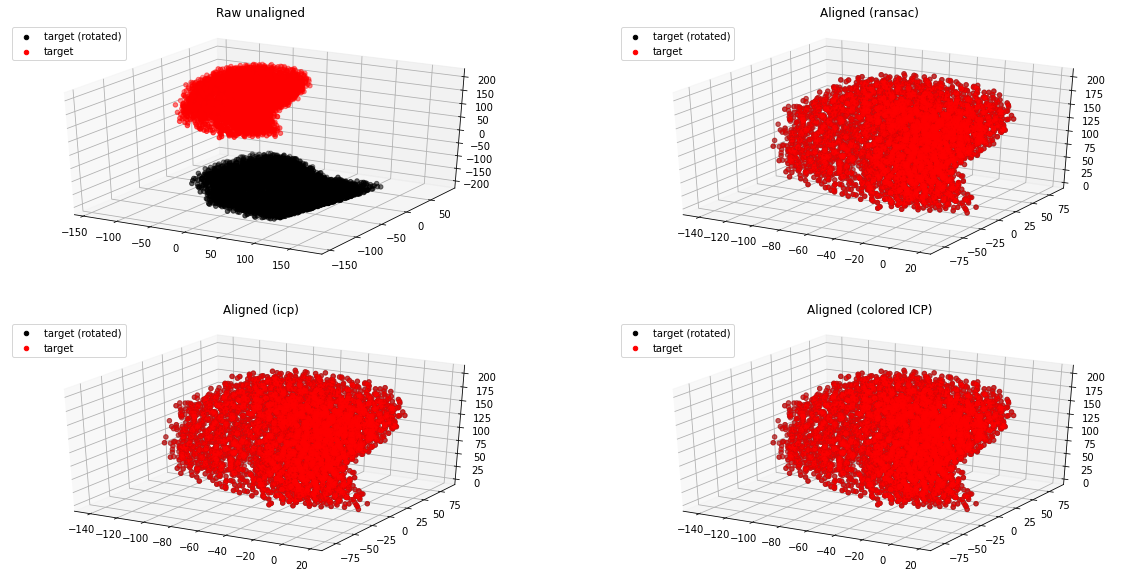

In [9]:
fig = plt.figure(figsize = (20,10))

subplot_loc = [221,222,223,224]
plot_titles = ["Raw unaligned", "Aligned (ransac)", "Aligned (icp)", "Aligned (colored ICP)"]
rotated_target_list = [np.asarray(target_rotated.points), np.asarray(target_rotated_aligned_ransac.points),
                      np.asarray(target_rotated_aligned_icp.points), np.asarray(target_rotated_aligned_colored_icp.points)]
target_points = np.asarray(target.points)


for i in range(len(subplot_loc)):
    ax = fig.add_subplot(subplot_loc[i], projection='3d')
    ax.scatter(xs = rotated_target_list[i][:,0], ys = rotated_target_list[i][:,1], zs = rotated_target_list[i][:,2], color='k',label = 'target (rotated)')
    ax.scatter(xs = target_points[:,0], ys = target_points[:,1], zs = target_points[:,2], color='r',label = 'target')
    ax.title.set_text(plot_titles[i])
    ax.legend(loc='upper left')




# Conclusion

The unregistered target and rotated target images, being non-overlapping, performed the worst on the registration evaluation metrics - it has zero `fitness` and an empty `correspondence set`.

After performing image registration, we observe a maximal fitness of 1.0 with one-to-one correspondence between every single point for all three algorithms tested (`RANSAC`, `ICP`, `Colored ICP`). In addition, upon examining the `MAE` metric for the colored ICP algorithm, we observe that the MAE score is 0.0, implying that the spots were mapped correctly.

Furthermore, by visualising the registration result, we observe that the rotated target image has indeed been successfully registered onto its counterpart.

Therefore, these algorithms pass the feasibility test as they recovered an exact correspondence map between the target image and its rotated counterpart. 